# Анализ поведения пользователей в мобильном приложении

# Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.  
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.  
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.  
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.  
#Описание данных
Каждая запись в логе — это действие пользователя, или событие.  
EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Выполнение проекта  
Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [3]:
def data_info(dataframe):
   display(dataframe.head()),
   display(dataframe.describe()),
   dataframe.info(),
   print(),
   print('Количество дубликатов:', dataframe.duplicated().sum()),
   print(),
   print('Доля дубликатов:', '{:.2%}'.format((dataframe.duplicated().sum() / len(dataframe)))),
   print(),
   print('Количество пропущенных значений:'),
   print(dataframe.isna().sum())

In [4]:
data_info(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество дубликатов: 413

Доля дубликатов: 0.17%

Количество пропущенных значений:
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


# Шаг 2. Подготовьте данные  
1) Замените названия столбцов на удобные для вас:

In [5]:
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'group'})

2) Проверьте пропуски. Откорректируйте, если нужно:

Пропущенных значений нет, дубликаты составляют всего 0,17% от общего размера датафрейма, исключим их:

In [6]:
df = df.drop_duplicates().reset_index(drop=True) # удаление дубликатов

3) Проверьте типы данных. Добавьте столбец даты и времени, а также отдельный столбец дат:

In [7]:
df['event_time'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [8]:
df['event_date'] = pd.to_datetime(df['event_timestamp'], unit='s').dt.date

In [9]:
df.head()

,event_name,user_id,event_timestamp,group,event_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Исследуемая таблица содержит 244126 строк без пропущенных значений, но с 413 строками-дубликатами. Названия столбцов не приведены к нижнему регистру, столбец с датой имеет целочисленный формат. Устранили эти недочеты.

# Шаг 3. Изучите и проверьте данные  
1) Сколько всего событий в логе?

Посчитаем логи — данные сервера о посещениях и действиях пользователей на сайте или в приложении.

In [10]:
events_count = df.shape[0]
print('Событий в логе:', events_count)

Событий в логе: 243713


2) Сколько всего пользователей в логе?

In [11]:
users_count = df['user_id'].nunique()
print('Пользователей в логе:', users_count)

Пользователей в логе: 7551


3) Сколько в среднем событий приходится на пользователя?

Поскольку в данных могут присутствовать аномальные значения, которые сильно исказят реальный результат, найдем среднее и медианное значения:

In [12]:
events_avg = df.groupby('user_id').agg({'event_name': 'count'})
print('Медианное число событий на пользователя:', round((events_avg['event_name'].median())))
print('Среднее число событий на пользователя:', round((events_avg['event_name'].mean())))

Медианное число событий на пользователя: 20
Среднее число событий на пользователя: 32


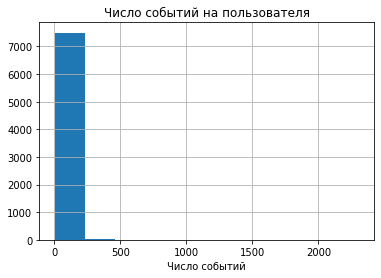

In [13]:
events_avg['event_name'].hist().set_title('Число событий на пользователя')
plt.xlabel("Число событий")
plt.show()

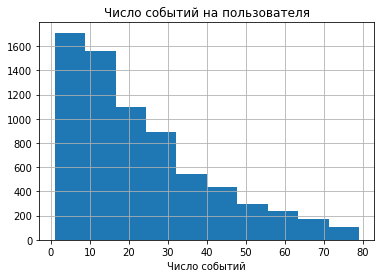

In [14]:
events_avg.query('event_name < 80')['event_name'].hist().set_title('Число событий на пользователя')
plt.xlabel("Число событий")
plt.show()

По гистограмме также можно отметить, что с ростом числа событий на пользователя уменьшается их количество, на большинство пользователей приходится до 32 событий, при этом число пользователей с количеством событий до 20 много больше.

4) Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [15]:
min_date = min(df['event_date'])
max_date = max(df['event_date'])
print('Минимальная дата:', min_date)
print('Максимальная дата:', max_date)

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


Располагаем данными за период с 25 июля 2019 года по 7 августа 2019 года.

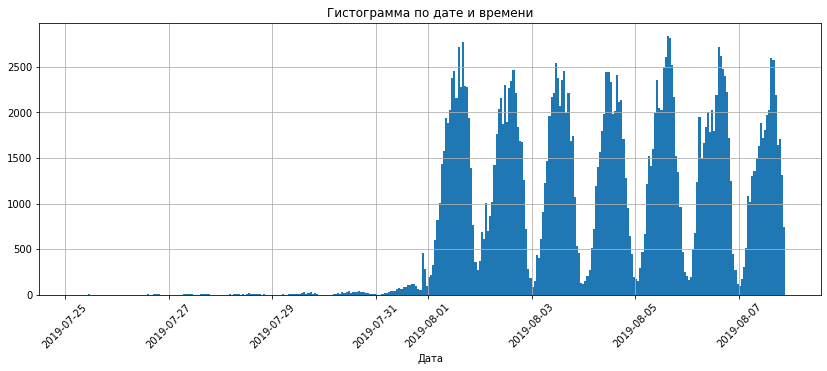

In [16]:
df['event_time'].hist(bins=14*24, figsize=(14, 5))
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.title('Гистограмма по дате и времени');

Судя по гистограмме, располагаем в полной мере данными с 1 августа 2019 года, отбросим более старые:

In [17]:
df_new = df.query('event_time >= "2019/08/01"')

5) Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [18]:
print('Доля потерянных пользователей:',round((1 - df_new['user_id'].nunique() /df['user_id'].nunique()) * 100, 2))
print('Количество потерянных пользователей:', df['user_id'].nunique() - df_new['user_id'].nunique())
print(' ')
print('Доля потерянных событий:',round((1 - df_new['event_name'].count() /df['event_name'].count()) * 100, 2))
print('Количество потерянных событий:', df['event_name'].count() - df_new['event_name'].count())

Доля потерянных пользователей: 0.23
Количество потерянных пользователей: 17
 
Доля потерянных событий: 1.16
Количество потерянных событий: 2826


6) Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [19]:
df = df_new
df.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


В таблице есть пользователи из всех трёх экспериментальных групп.

# Шаг 4. Изучите воронку событий  
1) Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [20]:
df.groupby('event_name').agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


В логах имеется 5 событий.  
Самое часто встречаемое событие, очевидно, MainScreenAppear - появление главного экрана приложения. Далее событие OffersScreenAppear - появление экрана с предложениями, чуть меньше пользователей доходят до CartScreenAppear - экрана корзины, еще меньше до окна PaymentScreenSuccessful - успешной оплаты. Совсем немного пользователей заходят в раздел Tutorial - руководства. 

2) Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [21]:
events_share = df.groupby('event_name').agg({'user_id':'nunique'})
events_share['users_share'] = round((events_share['user_id'] / df['user_id'].nunique() * 100), 2)
logs_funnel = events_share.sort_values(by='user_id', ascending=False).reset_index()
logs_funnel

,event_name,user_id,users_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Главный экран посетили 98,47% пользователей (остальные 1,53% могли переходить, например, из поисковой строки, из рассылки, из пуша), на странице с рекомендациями много меньше - 60,96%. Добавили товар в корзину 49,56% пользователей, а оплатили - 46,97%. Инструкции смотрело всего 11,15% пользователей.

3) Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Первые четыре события выше выстраиваются в последовательную цепочку - сначала пользователь заходит на главную страницу, затем получает персональные предложения, переходит в корзину и оплачивает заказ. Получать рекомендации человек может в любой момент цепочки, потому из дальнейшего анализа это событие исключим:

In [22]:
logs_funnel = logs_funnel.query('event_name != "Tutorial"')
df = df.query('event_name != "Tutorial"')

4) По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [23]:
logs_funnel['conversion'] = round((logs_funnel['user_id'] / logs_funnel['user_id'].shift() * 100),2)
logs_funnel['loss_users'] = 100 - logs_funnel['conversion']
logs_funnel

<ipython-input-23-f19a04374484>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_funnel['conversion'] = round((logs_funnel['user_id'] / logs_funnel['user_id'].shift() * 100),2)
<ipython-input-23-f19a04374484>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_funnel['loss_users'] = 100 - logs_funnel['conversion']


,event_name,user_id,users_share,conversion,loss_users
0,MainScreenAppear,7419,98.47,NaN,NaN
1,OffersScreenAppear,4593,60.96,61.91,38.09
2,CartScreenAppear,3734,49.56,81.30,18.70
3,PaymentScreenSuccessful,3539,46.97,94.78,5.22


5) На каком шаге теряете больше всего пользователей?

Больше всего пользователей (38,09%) теряется при переходе с "Главной страницы" в "Предложение".

6) Какая доля пользователей доходит от первого события до оплаты?

In [24]:
main_end = df.query('event_name=="MainScreenAppear"')['user_id'].nunique() #число уникальных пользователей, дошедших до события "Главная страница"
payment_end = df.query('event_name=="PaymentScreenSuccessful"')['user_id'].nunique() #число уникальных пользователей, дошедших до события "Оплата"
main_to_payment = round((payment_end / main_end) * 100, 2)
print('Доля пользователей, дошедших до оплаты:', main_to_payment)

Доля пользователей, дошедших до оплаты: 47.7


In [25]:
funnel = logs_funnel[['event_name', 'users_share']].query('event_name != "Tutorial"')
fig = go.Figure(
    go.Funnel(
        y=funnel['event_name'].to_list(),
        x=funnel['users_share'].to_list()))
fig.update_layout(autosize=False, width=800, height=500)
fig.show()

# Шаг 5. Изучите результаты эксперимента  
1) Сколько пользователей в каждой экспериментальной группе?

In [26]:
all_users = df.groupby('group').agg({'user_id': 'nunique'})
all_users

,user_id
group,
246,2483
247,2512
248,2535


2) Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Критерии успешного A/A-теста:   
а) Количество пользователей в различных группах различается не более, чем на 1%;

In [27]:
sample_A = df.query('group == 246')['user_id'].nunique()
sample_B = df.query('group == 247')['user_id'].nunique()

In [28]:
sample_diff_AB = round((abs(100 * ((sample_A / sample_B) -1))), 2)
print('Разница в количестве пользователей между группами 246 и 247 в процентах:', sample_diff_AB)

Разница в количестве пользователей между группами 246 и 247 в процентах: 1.15


б) Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же - соблюдено;  
в) Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости:  

Нулевая гипотеза - статистически значимых различий между двумя долями нет;  
Альтернативная гипотеза - между долями есть статистическая значимость.

In [29]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([df.query(f'group == 246 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
                      df.query(f'group == 247 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique()])

trials = np.array([df.query(f'group == 246')['user_id'].nunique(), df.query(f'group == 247')['user_id'].nunique()])

p1 = successes[0]/trials[0] # пропорция успехов в первой группе

p2 = successes[1]/trials[1] # пропорция успехов во второй группе

p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # пропорция успехов в комбинированном датасете:

difference = p1 - p2 # разница пропорций в датасетах

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])) # считаем статистику в ст.отклонениях стандартного нормального распределения

distr = st.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print("Результат теста для групп 246 и 247 и события PaymentScreenSuccessful")
print()
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Результат теста для групп 246 и 247 и события PaymentScreenSuccessful

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


г) Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно. Проверим этот факт:

In [30]:
df.groupby('user_id').agg({'group' : 'nunique'}).query('group > 1').count()

group    0
dtype: int64

Каждый пользователь состоит лишь в одной группе.

3) Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие.

In [31]:
users_share = df.query('event_name == "MainScreenAppear"').groupby('group').agg({'user_id': 'nunique'}) # число пользователей, совершивших событие MainScreenAppear, по группам
users_share['share'] = round((users_share['user_id'] / all_users['user_id'] * 100),2)
users_share

,user_id,share
group,,
246,2450,98.67
247,2476,98.57
248,2493,98.34


Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Сформулируем гипотезы:  
Нулевая - доли уникальных посетителей, побывавших на этапе воронки, одинаковы;  
Альтернативная - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [32]:
# Создаю сводную таблицу с количеством пользователей в каждом событии для каждой группы, а также для группы 246+247
user_counts = df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc="nunique")
user_counts['246+247'] = user_counts[246] + user_counts[247]
user_counts = user_counts.reset_index()
user_counts

group,event_name,246,247,248,246+247
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [33]:
# расчитываю общее количество пользователей в каждой группе, а также в комбинированной 246+247
total = df.groupby('group').agg({'user_id':'nunique'}).T
total['246+247'] = total[246] + total[247]
total

group,246,247,248,246+247
user_id,2483,2512,2535,4995


In [34]:
def hypothesis_test(group1, group2, alpha):
  for i in user_counts.index:
      
      p1 = user_counts[group1][i] / total[group1] # пропорция успехов в первой группе
      
      p2 = user_counts[group2][i] / total[group2] # пропорция успехов во второй группе
      
      p_combined = (user_counts[group1][i] + user_counts[group2][i]) / (total[group1] + total[group2]) # пропорция успехов в комбинированном датасете
      
      difference = p1 - p2 # разница пропорций в датасетах
  
      z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/total[group1] + 1/total[group2]))
      
      distr = st.norm(0, 1) 
      
      p_value = (1 - distr.cdf(abs(z_value))) * 2

      print('p-значение: ', p_value, 'для события', user_counts['event_name'][i])

      if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
      else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [35]:
print('Сравнение групп 246 и 247:')
print()
hypothesis_test(246, 247, 0.05)
print()
print('Сравнение групп 246 и 248:')
print()
hypothesis_test(246, 248, 0.05)
print()
print('Сравнение групп 247 и 248:')
print()
hypothesis_test(247, 248, 0.05)

Сравнение групп 246 и 247:

p-значение:  [0.22867644] для события CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.75267034] для события MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.24786097] для события OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11446628] для события PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение групп 246 и 248:

p-значение:  [0.08067368] для события CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.33871141] для события MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.21442477] для события OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p

Разбиение на группы работает корректно - статистически значимых различий между группами 246/247, 247/248, 246/248 ни с одним событием нет.

4) Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [36]:
print('Сравнение групп 246+247 и 248:')
print()
hypothesis_test('246+247', 248, 0.05)

Сравнение групп 246+247 и 248:

p-значение:  [0.18683559] для события CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.34866843] для события MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.44582745] для события OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.61079187] для события PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Согласно проведенным тестам, статистически значимых различий ни между контрольными 246 и 247 группами, ни между контрольными и экспериментальной, нет. Измененный дизайнерами шрифт никак не повлиял на воронку продаж продуктового приложения.

5) Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При множественном тесте с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости для уменьшения FWER - метод Бонферрони, метод Холма, метод Шидака.

# Вывод:  
В ходе проведенного выше анализа данных можно отметить:  

1) В исследовании представлены данные с 25 июля 2019 года, причем в полном объеме - только в период с 1 по 7 августа 2019;  
2) В данных присутствуют пользователи из трех экспериментальных групп - 246, 247 и 248;  
3) Пользователи мобильного приложения могли участвовать в пяти событиях: переходить на главную страницу, затем на страницу с персональными предложениями, в корзину, оплачивать продукты и смотреть руководства. Первые четыре шли последовательно, с последним пунктом можно было ознакомиться на любом шаге;  
4) Каждый пользователь в среднем совершает 20 переходов по событиям приложения;  
5) Больше всего пользователей (почти 40%) терялось при переходе с главной страницы на страницу с персональными предложениями - рекомендовано протестировать этот переход;  
6) Почти 48% пользователей при переходе на главную страницу в итоге совершает заказ через приложение;  
7) Почти 95% пользователей после оформления корзины оплачивает покупку;  
8) В раздел с инструкциями переходит всего 11% пользователей - необходимо поработать с наполнением или привлечением пользователей сюда;  
9) При сравнении контрольных групп между собой, а также с экспериментальной группой, не найдено статистически значимых различий при уровне значимости 0,05 - данные собраны качественно, а замена шрифтов в приложении никак не повлияла на поведение пользователей.